In [1]:
import json 
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os
import pandas as pd
import numpy as np

In [2]:
comments_dir = "../data/filtered/comments"
posts_dir = "../data/filtered/posts"
google_data_files = ["../data/raw/google_trends_since_june_full_names.csv",
                      "../data/raw/google_trends_since_june_surnames.csv"]
polls_dir = "../data/raw/presidential_general_averages.csv"
output_dir = "../data/processed"

### Google trends

In [79]:
file_full_name = pd.read_csv(google_data_files[0], skiprows=1)
file_surname = pd.read_csv(google_data_files[1], skiprows=1)

# merge the two dataframes
google_df = pd.merge(file_full_name, file_surname, on="Día", how="inner")
print(google_df.columns)

# change column names

google_df.columns = ["date", "Kamala_Harris", "Joe_Biden", "Donald_Trump", "Harris", "Biden", "Trump"]

# replace "<1" with 0
google_df = google_df.replace("<1", 0)

# convert columns to numeric
google_df["Kamala_Harris"] = pd.to_numeric(google_df["Kamala_Harris"])
google_df["Joe_Biden"] = pd.to_numeric(google_df["Joe_Biden"])
google_df["Donald_Trump"] = pd.to_numeric(google_df["Donald_Trump"])
google_df["Harris"] = pd.to_numeric(google_df["Harris"])
google_df["Biden"] = pd.to_numeric(google_df["Biden"])
google_df["Trump"] = pd.to_numeric(google_df["Trump"])

google_df['all_Kamala_Harris'] = (google_df['Kamala_Harris'] + google_df['Harris']) / 2
google_df['all_Joe_Biden'] = (google_df['Joe_Biden'] + google_df['Biden']) / 2
google_df['all_Donald_Trump'] = (google_df['Donald_Trump'] + google_df['Trump']) / 2

google_df

Index(['Día', 'Kamala Harris: (Estados Unidos)', 'Joe Biden: (Estados Unidos)',
       'Donald Trump: (Estados Unidos)', 'Harris: (Estados Unidos)',
       'Biden: (Estados Unidos)', 'Trump: (Estados Unidos)'],
      dtype='object')


,date,Kamala_Harris,Joe_Biden,Donald_Trump,Harris,Biden,Trump,all_Kamala_Harris,all_Joe_Biden,all_Donald_Trump
0,2024-06-01,0,1,6,1,1,6,0.5,1.0,6.0
1,2024-06-02,0,1,5,1,1,5,0.5,1.0,5.0
2,2024-06-03,0,1,3,1,1,4,0.5,1.0,3.5
3,2024-06-04,0,1,3,1,2,3,0.5,1.5,3.0
4,2024-06-05,0,1,2,1,2,3,0.5,1.5,2.5
...,...,...,...,...,...,...,...,...,...,...
114,2024-09-23,2,0,3,3,0,4,2.5,0.0,3.5
115,2024-09-24,2,0,4,2,0,4,2.0,0.0,4.0
116,2024-09-25,2,0,3,3,0,4,2.5,0.0,3.5
117,2024-09-26,2,0,3,3,0,4,2.5,0.0,3.5


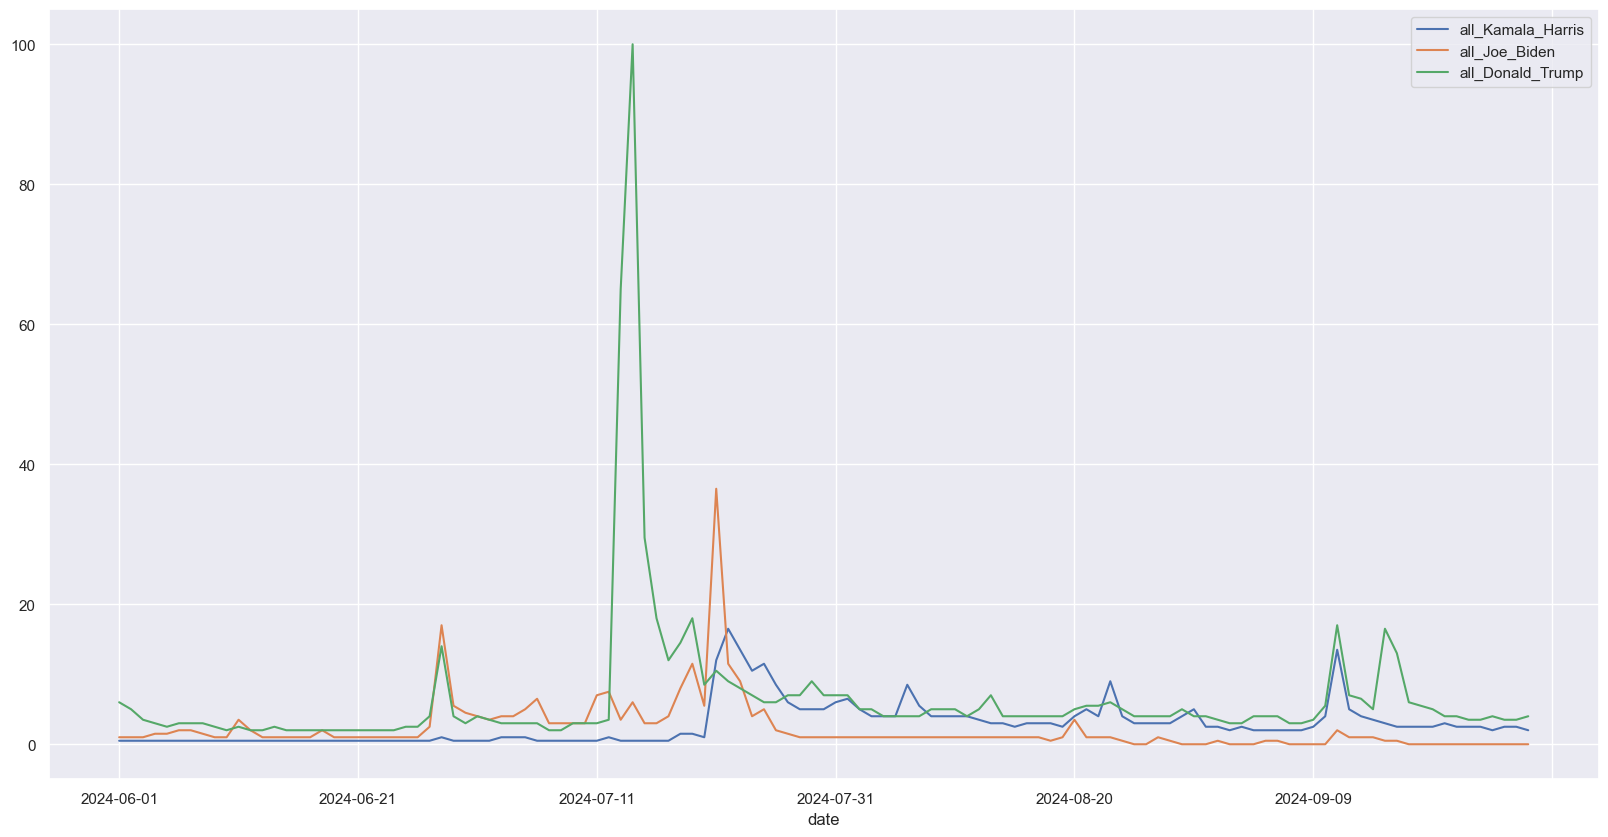

In [80]:
# plot all kamala, all biden, all trump
google_df.plot(x='date', y=['all_Kamala_Harris', 'all_Joe_Biden', 'all_Donald_Trump'], figsize=(20, 10))
plt.show()

In [81]:
google_df.to_csv(os.path.join(output_dir, "google_trends.csv"), columns=["date", "all_Kamala_Harris", "all_Joe_Biden", "all_Donald_Trump"], index=False)

### Presidential polls

In [82]:
# read polls data
polls_df = pd.read_csv(polls_dir)

# get data from 2024-06-01 to 2024-09-27
polls_df = polls_df[polls_df["date"] >= "2024-06-01"]
polls_df = polls_df[polls_df["date"] <= "2024-09-27"]

polls_df.head()

,candidate,date,pct_trend_adjusted,state,cycle,party,pct_estimate,hi,lo
21354,Trump,2024-09-27,NaN,Arizona,2024,REP,48.03695,49.472240,46.647695
21355,Harris,2024-09-27,NaN,Arizona,2024,DEM,46.76445,48.279405,45.246513
21356,Trump,2024-09-26,NaN,Arizona,2024,REP,47.89430,49.230528,46.461395
21357,Harris,2024-09-26,NaN,Arizona,2024,DEM,47.07260,48.606225,45.628150
21358,Trump,2024-09-25,NaN,Arizona,2024,REP,47.91320,49.456457,46.390183


In [83]:
polls_df.isna().sum()

candidate                0
date                     0
pct_trend_adjusted    3312
state                    0
cycle                    0
party                    0
pct_estimate             0
hi                       0
lo                       0
dtype: int64

In [84]:
polls_df.drop(columns=["pct_trend_adjusted"], inplace=True)

In [85]:
polls_df.sort_values(by="date", inplace=True)

In [86]:
# create a new df with date, candidate and mean of pct_estimate

polls_df_2 = polls_df.groupby(["date", "candidate"]).agg({"pct_estimate": "mean"}).reset_index()
polls_df_2

,date,candidate,pct_estimate
0,2024-06-01,Biden,38.668283
1,2024-06-01,Kennedy,9.181320
2,2024-06-01,Trump,42.883383
3,2024-06-02,Biden,38.705211
4,2024-06-02,Kennedy,9.238094
...,...,...,...
311,2024-09-25,Trump,46.302787
312,2024-09-26,Harris,48.572300
313,2024-09-26,Trump,46.183492
314,2024-09-27,Harris,48.466126


In [87]:
# drop where candidate is Kennedy
polls_df_2 = polls_df_2[polls_df_2["candidate"] != "Kennedy"]

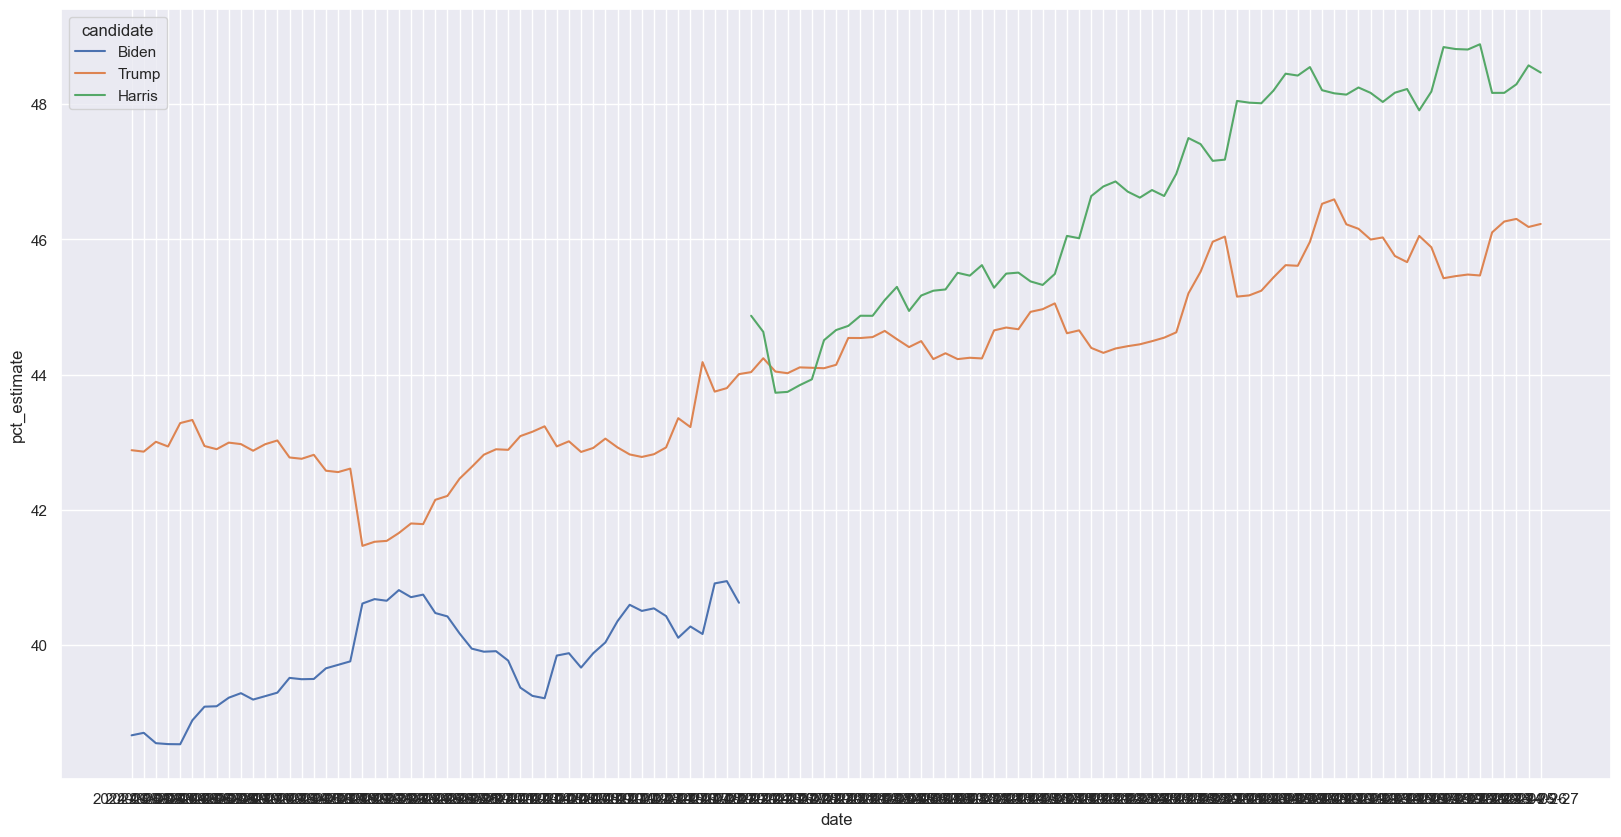

In [88]:
# plot by candidate over time
sns.set(rc={'figure.figsize':(20,10)})

sns.lineplot(data=polls_df_2, x="date", y="pct_estimate", hue="candidate")
plt.show()

In [89]:
polls_df_2.to_csv(os.path.join(output_dir, "polls.csv"), index=False)

### Comments

In [90]:
def is_valid_comment(comment):
    body = comment["body"].lower()
    regex = r"(biden|trump|harris|donald|joe|kamala)"
    if re.search(regex, body):
        return True
    return False

In [91]:
final_df = pd.DataFrame()


for file in os.listdir(comments_dir):
    # read json file
    df = pd.read_json(os.path.join(comments_dir, file), lines=True) 

    # filter by valid comments
    bodies = df["body"].tolist()
    df['is_valid'] = df.apply(is_valid_comment, axis=1)
    df = df[df["is_valid"]]

    # remove columns
    df.drop(columns=["is_valid", "created", "author"], inplace=True)

    # convert to date
    df['date_day'] = df['datetime'].dt.date

    # remove links from body
    df['body'] = df['body'].apply(lambda x: re.sub(r"http\S+", "", x))
    final_df = pd.concat([final_df, df])

    
final_df.head()

,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day
1,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01
6,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01
14,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...,2024-06-01
15,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01
19,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01


In [92]:
final_df.to_csv(os.path.join(output_dir, "comments.csv"), index=False)

### Posts

In [93]:
def is_valid_post(post):
    body = post["body"].lower()
    title = post["title"].lower()
    regex = r"(biden|trump|harris|donald|joe|kamala)"
    if re.search(regex, body) or re.search(regex, title):
        return True
    return False

In [94]:
final_df = pd.DataFrame()

for file in os.listdir(posts_dir):
    if file.endswith(".txt"):
        continue

    # read json file
    df = pd.read_json(os.path.join(posts_dir, file), lines=True) 

    # filter by valid comments
    bodies = df["body"].tolist()
    df['is_valid'] = df.apply(is_valid_comment, axis=1)
    df = df[df["is_valid"]]

    # remove columns
    df.drop(columns=["is_valid", "created", "author", "id", "subreddit_id", "url"], inplace=True)

    # convert to date
    df['date_day'] = df['datetime'].dt.date

    # remove links from body
    df['body'] = df['body'].apply(lambda x: re.sub(r"http\S+", "", x))
    
    final_df = pd.concat([final_df, df])

final_df.head()

,subreddit,name,datetime,score,ratio,title,body,date_day
1,Conservative,t3_1d5b2pn,2024-06-01 02:57:34,0,0.14,Where can I get a T-shirt?,I’m looking for\n\n\nYELLIN FOR THE FELLON\n ...,2024-06-01
2,Conservative,t3_1d5b496,2024-06-01 03:00:01,0,0.36,great summary on the commie dirtbag nonsense,[\n\nCNN Senior Legal Analyst Describes How Th...,2024-06-01
5,Conservative,t3_1d5cxhf,2024-06-01 04:39:48,0,0.48,Will local Texas DAs start grand jury investig...,Since 2021 millions of migrants have been allo...,2024-06-01
7,Conservative,t3_1d5fbhl,2024-06-01 06:58:11,0,0.50,Good news about Trump's verdict,MAGA Senators are making a stand. Within 48 h...,2024-06-01
11,Conservative,t3_1d5ti3t,2024-06-01 20:31:24,95,0.65,Minority voters respond to the Trump verdict.,[\n\n[\n\n[\n\n[\n\n[\n\n[\n\n[\n\nTL;DR: Min...,2024-06-01


In [95]:
final_df.to_csv(os.path.join(output_dir, "posts.csv"), index=False)

### All data joined together

In [96]:
posts = pd.read_csv(os.path.join(output_dir, "posts.csv"))
comments = pd.read_csv(os.path.join(output_dir, "comments.csv"))
polls = pd.read_csv(os.path.join(output_dir, "polls.csv"))
google = pd.read_csv(os.path.join(output_dir, "google_trends.csv"))

In [97]:
polls.head()

,date,candidate,pct_estimate
0,2024-06-01,Biden,38.668283
1,2024-06-01,Trump,42.883383
2,2024-06-02,Biden,38.705211
3,2024-06-02,Trump,42.862000
4,2024-06-03,Biden,38.551967


In [98]:
google.head()

,date,all_Kamala_Harris,all_Joe_Biden,all_Donald_Trump
0,2024-06-01,0.5,1.0,6.0
1,2024-06-02,0.5,1.0,5.0
2,2024-06-03,0.5,1.0,3.5
3,2024-06-04,0.5,1.5,3.0
4,2024-06-05,0.5,1.5,2.5


In [99]:
# create a json with posts and add a field "type" with value "post", do the same with comments
posts["type"] = "post"
comments["type"] = "comment"

json_posts = posts.to_dict(orient="records")
json_comments = comments.to_dict(orient="records")

# join the two lists

json_data = json_posts + json_comments

polls_candidate_names = polls["candidate"].unique()

google_columns_candidate_names = list(google.columns[1:4])

for doc in json_data:
    # get the date
    date = doc["date_day"]
    for candidate in polls_candidate_names:

        # get the value of the candidate in the polls on said date
        polls_value = polls[(polls["date"] == date) & (polls["candidate"] == candidate)]["pct_estimate"].values
        if len(polls_value) > 0:
            doc[f'polls_{candidate}'] = polls_value[0]
        else:
            doc[f'polls_{candidate}'] = None

    for candidate in google_columns_candidate_names:
        # get the value of the candidate in the google trends on said date
        google_value = google[google["date"] == date][candidate].values
        if len(google_value) > 0:
            doc[f"google_{candidate.split('_')[-1]}"] = google_value[0]
        else:
            doc[f"google_{candidate.split('_')[-1]}"] = None

json_data[0]

    


{'subreddit': 'Conservative',
 'name': 't3_1d5b2pn',
 'datetime': '2024-06-01 02:57:34',
 'score': 0,
 'ratio': 0.140000000596046,
 'title': 'Where can I get a T-shirt?',
 'body': 'I’m looking for\n\n\nYELLIN FOR THE FELLON\n               VOTE\n      TRUMP 2024',
 'date_day': '2024-06-01',
 'type': 'post',
 'polls_Biden': 38.668283333333335,
 'polls_Trump': 42.883383333333335,
 'polls_Harris': None,
 'google_Harris': 0.5,
 'google_Biden': 1.0,
 'google_Trump': 6.0}

In [100]:
# create a dataframe from the json
df = pd.DataFrame(json_data)

# drop columns name, datetime, post_id, id, parent, ratio, upvotes, type and score from the dataframe
df.drop(columns=["name", "datetime", "post_id", "id", "parent", "ratio", "upvotes", "type", "score", "subreddit"], inplace=True)

# filter by date_day being <= 2024-09-27
df = df[df["date_day"] <= "2024-09-27"]

# apply .fillna(0) to 'polls_Biden' and 'polls_Harris' columns
#df.loc[:, ['polls_Biden', 'polls_Harris']] = df.loc[:, ['polls_Biden', 'polls_Harris']].fillna(0)

# apply .fillna(' ') to 'title' column
#df['title'] = df['title'].fillna(' ')

df

,title,body,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump
0,Where can I get a T-shirt?,I’m looking for\n\n\nYELLIN FOR THE FELLON\n ...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0
1,great summary on the commie dirtbag nonsense,[\n\nCNN Senior Legal Analyst Describes How Th...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0
2,Will local Texas DAs start grand jury investig...,Since 2021 millions of migrants have been allo...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0
3,Good news about Trump's verdict,MAGA Senators are making a stand. Within 48 h...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0
4,Minority voters respond to the Trump verdict.,[\n\n[\n\n[\n\n[\n\n[\n\n[\n\n[\n\nTL;DR: Min...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0
...,...,...,...,...,...,...,...,...,...
141162,NaN,You misspelled Donald Trump and JD Vance.,2024-09-27,NaN,46.227953,48.466126,2.0,0.0,4.0
141163,NaN,Trump doesn't want Ukraine to surrender.,2024-09-27,NaN,46.227953,48.466126,2.0,0.0,4.0
141164,NaN,I have yet to see any sort of evidence that th...,2024-09-27,NaN,46.227953,48.466126,2.0,0.0,4.0
141165,NaN,If you live in North Carolina or Georgia pleas...,2024-09-27,NaN,46.227953,48.466126,2.0,0.0,4.0


In [101]:
# show nan values
df.isna().sum()

title            140548
body                299
date_day              0
polls_Biden       52846
polls_Trump        4547
polls_Harris      92868
google_Harris         0
google_Biden          0
google_Trump          0
dtype: int64

In [102]:
df.to_csv(os.path.join(output_dir, "final_dataset.csv"), index=False)

In [103]:
# join the sentiment analysis data to the df on index
sentiment = pd.read_csv("../data/processed/love_hate.csv")

df = df.join(sentiment)
df

,title,body,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump,donald_trump_love,donald_trump_hate,joe_biden_love,joe_biden_hate,kamala_harris_love,kamala_harris_hate
0,Where can I get a T-shirt?,I’m looking for\n\n\nYELLIN FOR THE FELLON\n ...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,great summary on the commie dirtbag nonsense,[\n\nCNN Senior Legal Analyst Describes How Th...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0,0.000000,0.000000,0.575917,0.424083,0.000000,0.000000
2,Will local Texas DAs start grand jury investig...,Since 2021 millions of migrants have been allo...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0,0.543043,0.456957,0.000000,0.000000,0.000000,0.000000
3,Good news about Trump's verdict,MAGA Senators are making a stand. Within 48 h...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0,0.000000,0.000000,0.565068,0.434932,0.000000,0.000000
4,Minority voters respond to the Trump verdict.,[\n\n[\n\n[\n\n[\n\n[\n\n[\n\n[\n\nTL;DR: Min...,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0,0.485946,0.514054,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141162,NaN,You misspelled Donald Trump and JD Vance.,2024-09-27,NaN,46.227953,48.466126,2.0,0.0,4.0,0.000000,0.000000,0.000000,0.000000,0.414675,0.585325
141163,NaN,Trump doesn't want Ukraine to surrender.,2024-09-27,NaN,46.227953,48.466126,2.0,0.0,4.0,0.195985,0.804015,0.000000,0.000000,0.000000,0.000000
141164,NaN,I have yet to see any sort of evidence that th...,2024-09-27,NaN,46.227953,48.466126,2.0,0.0,4.0,0.332384,0.667616,0.000000,0.000000,0.000000,0.000000
141165,NaN,If you live in North Carolina or Georgia pleas...,2024-09-27,NaN,46.227953,48.466126,2.0,0.0,4.0,0.333486,0.666514,0.000000,0.000000,0.000000,0.000000


In [105]:
# count nan values in the dataframe
df.isna().sum()

title                 140548
body                     299
date_day                   0
polls_Biden            52846
polls_Trump             4547
polls_Harris           92868
google_Harris              0
google_Biden               0
google_Trump               0
donald_trump_love          1
donald_trump_hate          1
joe_biden_love             1
joe_biden_hate             1
kamala_harris_love         1
kamala_harris_hate         1
dtype: int64

### Sentiment

In [2]:
from transformers import pipeline
pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device='cuda')

In [ ]:
# Function to find entities in a text
def find_entities(text):
    entities = []
    regex = r"(biden|trump|harris|donald|joe|kamala)"
    for match in re.finditer(regex, text.lower()):
        entities.append(match.group())
    return entities


def get_sentiment_labels_entity(entity):
    return [f'{entity}_love', f'{entity}_hate']

def get_sentiment_towards_entity(text, entity):
    labels = get_sentiment_labels_entity(entity)
    sentiment_entry = pipe(text, labels)
    custom_order = [f'{entity}_love', f'{entity}_hate']
    label_score_map = dict(zip(sentiment_entry['labels'], sentiment_entry['scores']))
    sorted_labels = sorted(sentiment_entry['labels'], key=lambda x: custom_order.index(x))
    sorted_scores = [label_score_map[label] for label in sorted_labels]
    return {"labels": sorted_labels, "scores": sorted_scores}





def process_sentiment(text):
    entities = find_entities(text)
    result = {}

    new_entities = ['donald_trump', 'joe_biden', 'kamala_harris']

    for mixed_entity in new_entities:
        roots = mixed_entity.split("_")
        final_sum = np.zeros(2)
        is_in_text = 0
        for r in roots:
            if r in entities:
                is_in_text += 1
                sentiment = get_sentiment_towards_entity(text, r)
                final_sum += np.array(sentiment["scores"])

        if is_in_text > 0:
            final_sum = final_sum / is_in_text
            result[mixed_entity] = {"labels": ["love", "hate"], "scores": final_sum.tolist()}
        else:
            result[mixed_entity] = {"labels": ["love", "hate"], "scores": [0, 0]}




    return result

process_sentiment(text)


In [7]:
df = pd.read_csv(os.path.join(output_dir, "final_dataset.csv"))

In [ ]:
text = df.iloc[141162]["body"]
print(text)

process_sentiment(text)

In [ ]:
import tqdm
columns = ['donald_trump_love', 'donald_trump_hate', 'joe_biden_love', 'joe_biden_hate', 'kamala_harris_love', 'kamala_harris_hate']
candidates = ['donald_trump', 'joe_biden', 'kamala_harris']
sentiment_df = pd.DataFrame(columns=columns)
for index, row in tqdm.tqdm(df.iterrows()):
    text = row['title'] + " " + row['body']
    sentiment = process_sentiment(text)
    row_values = []
    for candidate in candidates:
        row_values += sentiment[candidate]["scores"]
    sentiment_df.loc[index] = row_values

sentiment_df.head()
        



In [19]:
sentiment_df.iloc[141162]

donald_trump_positive     0.000000
donald_trump_negative     0.000000
joe_biden_positive        0.000000
joe_biden_negative        0.000000
kamala_harris_positive    0.330522
kamala_harris_negative    0.669478
Name: 141162, dtype: float64

In [12]:
sentiment_df.to_csv(os.path.join(output_dir, "love_hate.csv"), index=False)

### Normalization

In [42]:
df = pd.read_csv(os.path.join(output_dir, "final_dataset.csv"))
sentiment = pd.read_csv(os.path.join(output_dir, "love_hate.csv"))
# replace in sentiment for all candidates, the love and hate collumns with 0 values with Nan if both are 0

for row in sentiment.iterrows():
    if row[1]["donald_trump_love"] == 0 and row[1]["donald_trump_hate"] == 0:
        sentiment.at[row[0], "donald_trump_love"] = np.nan
        sentiment.at[row[0], "donald_trump_hate"] = np.nan

    if row[1]["joe_biden_love"] == 0 and row[1]["joe_biden_hate"] == 0:
        sentiment.at[row[0], "joe_biden_love"] = np.nan
        sentiment.at[row[0], "joe_biden_hate"] = np.nan

    if row[1]["kamala_harris_love"] == 0 and row[1]["kamala_harris_hate"] == 0:
        sentiment.at[row[0], "kamala_harris_love"] = np.nan
        sentiment.at[row[0], "kamala_harris_hate"] = np.nan

    

df = df.join(sentiment)

# group the sentiments by day, keeping the mean, and 

df['date_day'] = pd.to_datetime(df['date_day'])
numeric_df = df.select_dtypes(include=[np.number])
df = df[['date_day']].join(numeric_df).groupby("date_day").mean().reset_index()


/var/folders/80/6r8bxtmd43bgpqvzbwvlm7nm0000gn/T/ipykernel_3721/2651069252.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(output_dir, "final_dataset.csv"))


In [43]:
df.head()

,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump,donald_trump_love,donald_trump_hate,joe_biden_love,joe_biden_hate,kamala_harris_love,kamala_harris_hate
0,2024-06-01,38.668283,42.883383,NaN,0.5,1.0,6.0,0.334880,0.665120,0.446093,0.553907,0.435604,0.564396
1,2024-06-02,38.705211,42.862000,NaN,0.5,1.0,5.0,0.374042,0.625958,0.457451,0.542549,0.450699,0.549301
2,2024-06-03,38.551967,43.007789,NaN,0.5,1.0,3.5,0.278365,0.721635,0.522103,0.477897,NaN,NaN
3,2024-06-04,38.538339,42.938017,NaN,0.5,1.5,3.0,0.367021,0.632979,0.489895,0.510105,0.467429,0.532571
4,2024-06-05,38.536200,43.284085,NaN,0.5,1.5,2.5,0.297008,0.702992,0.370519,0.629481,0.526755,0.473245


In [44]:
df['polls_Biden'] = df['polls_Biden'] / 100
df['polls_Harris'] = df['polls_Harris'] / 100
df['polls_Trump'] = df['polls_Trump'] / 100

In [45]:
df['google_Biden'] = df['google_Biden'] / 100
df['google_Harris'] = df['google_Harris'] / 100
df['google_Trump'] = df['google_Trump'] / 100

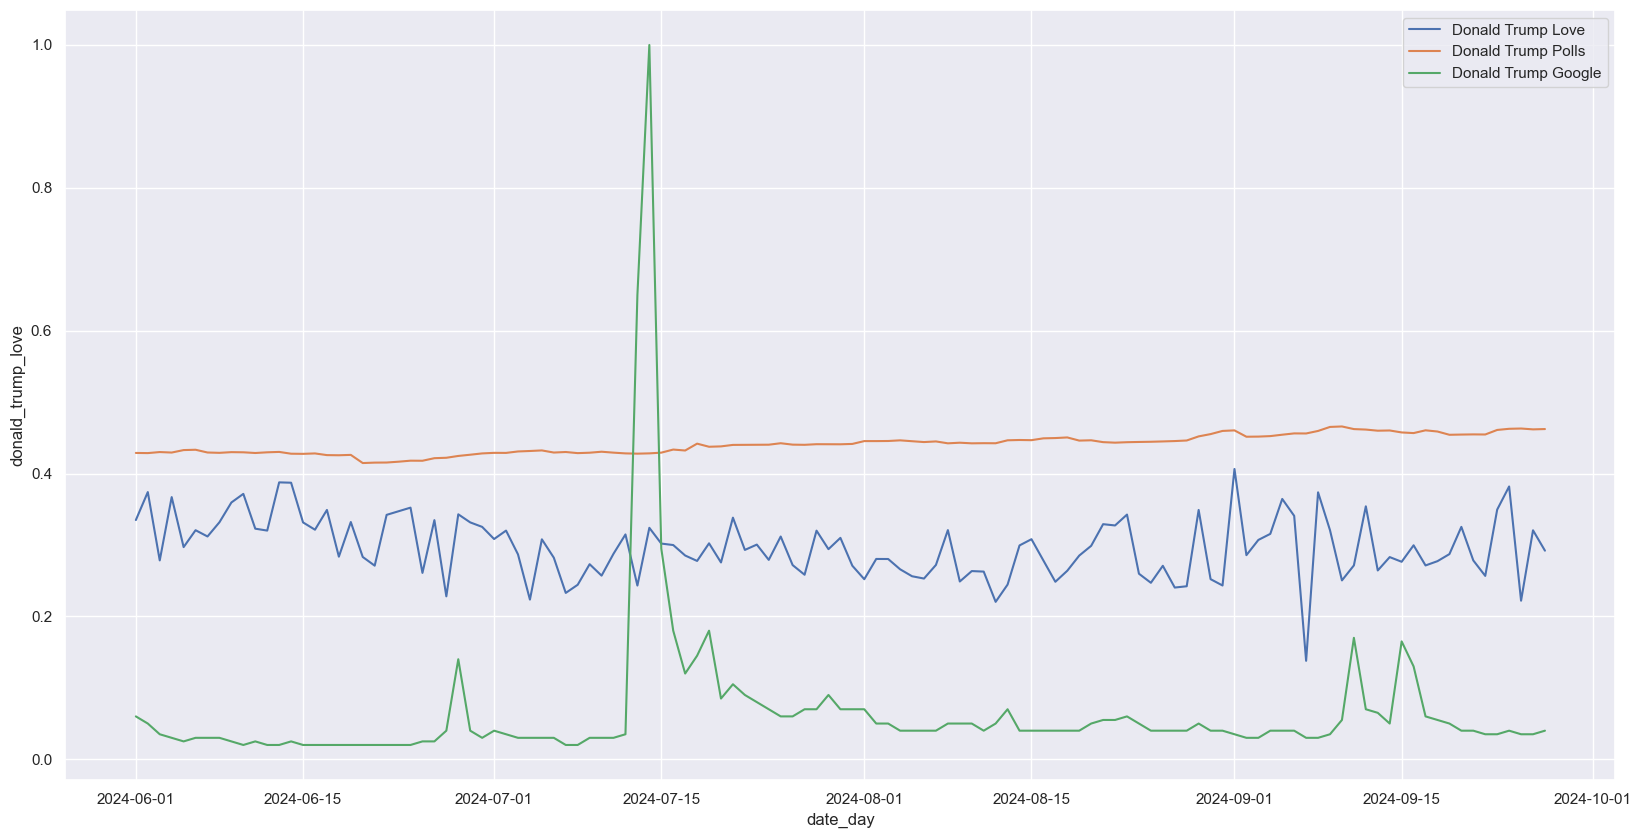

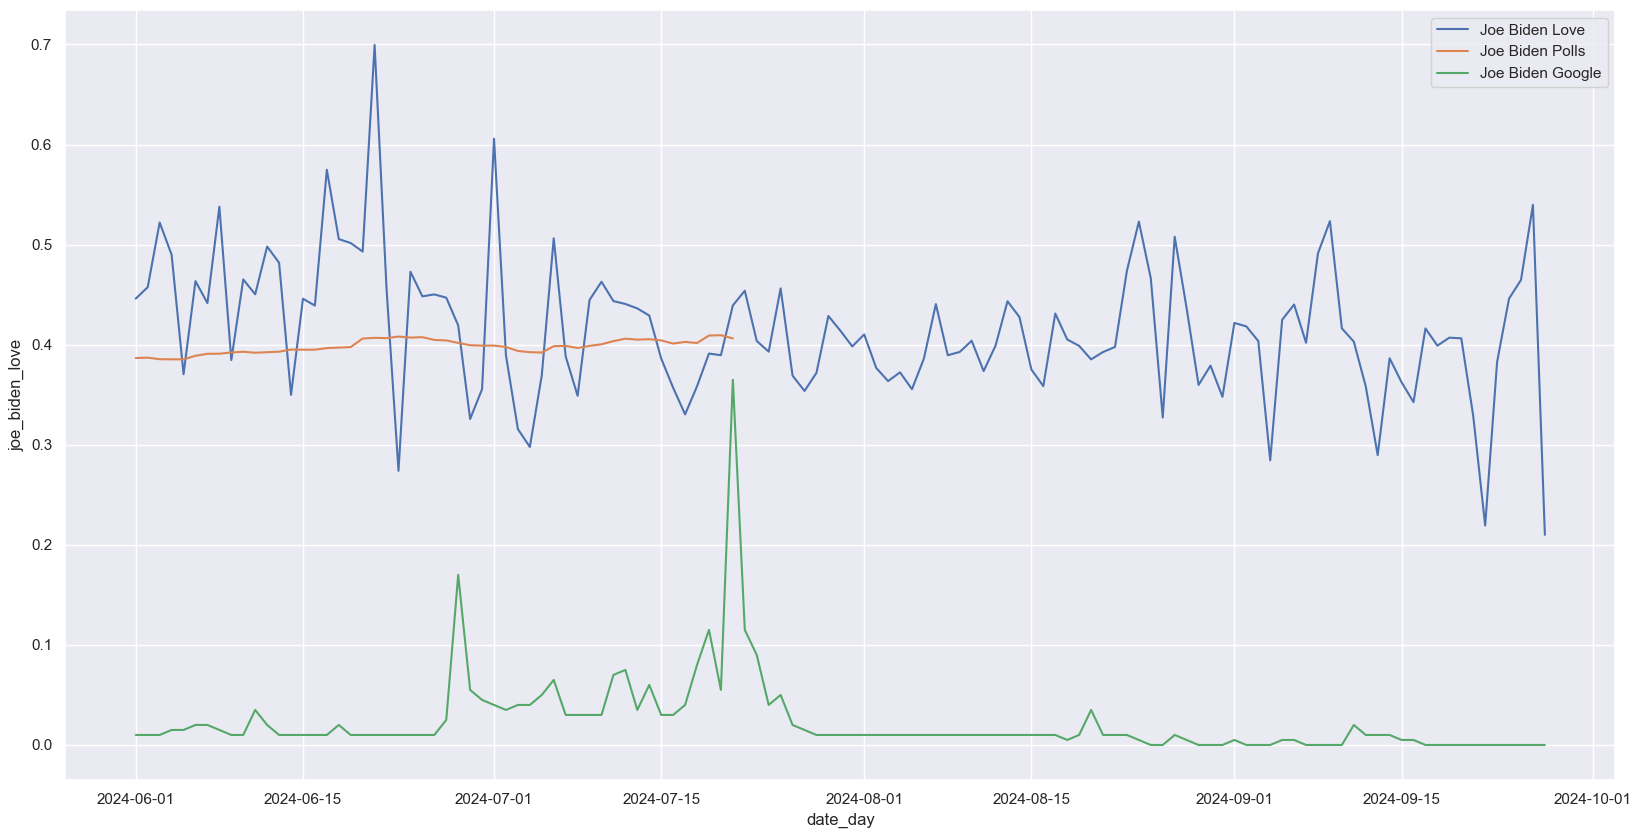

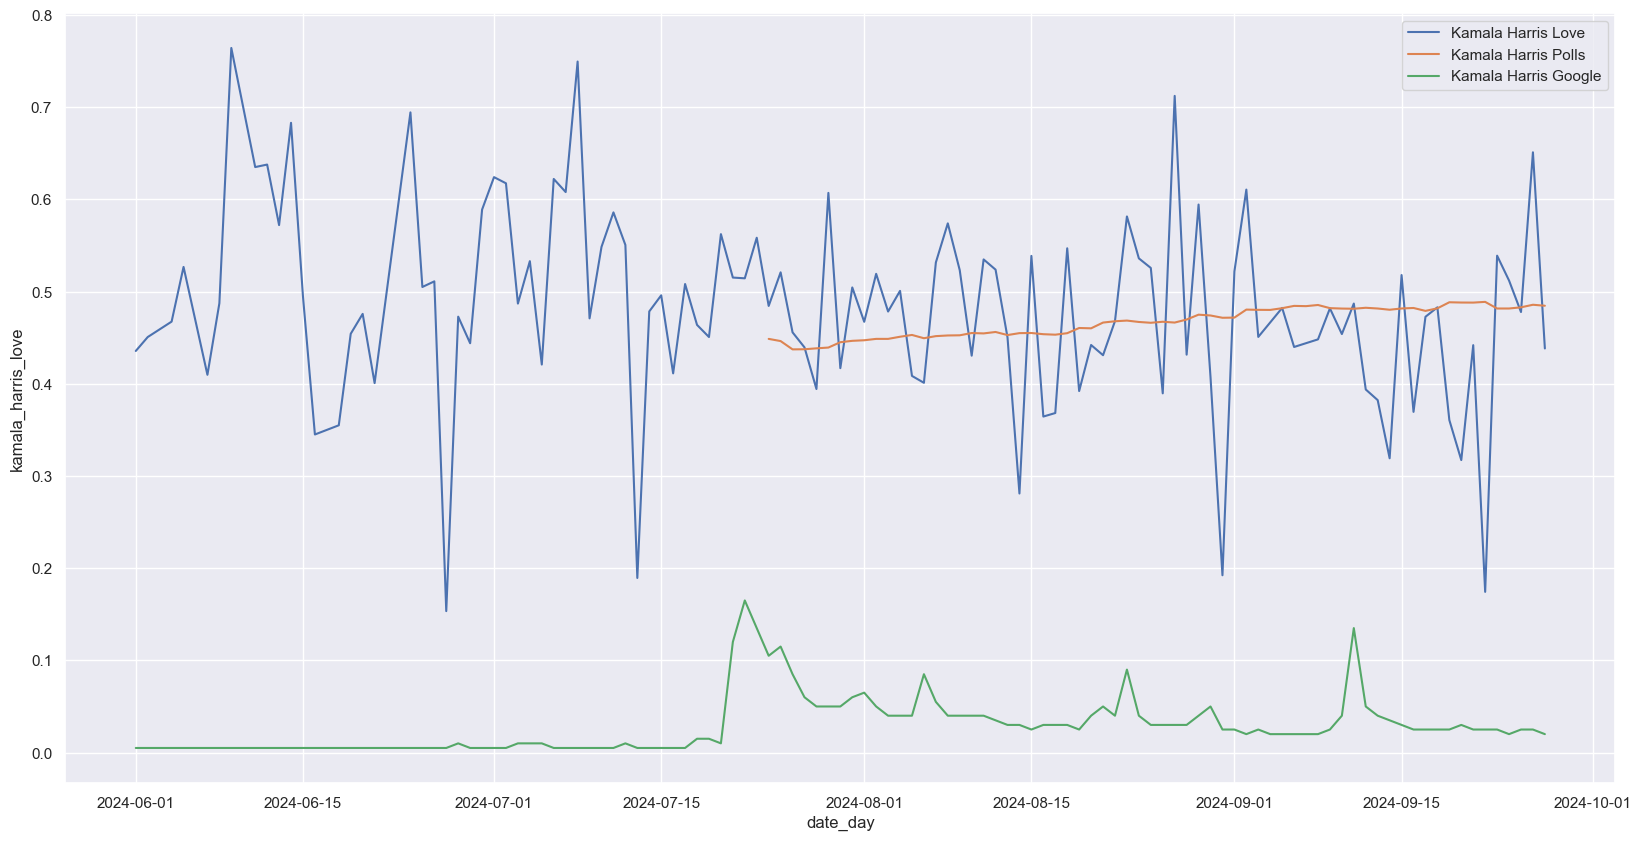

In [47]:
# make 3 plots, one for each candidate, with the sentiment over time
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(data=df, x="date_day", y="donald_trump_love", label = "Donald Trump Love")
sns.lineplot(data=df, x="date_day", y="polls_Trump", label = "Donald Trump Polls")
sns.lineplot(data=df, x="date_day", y="google_Trump", label = "Donald Trump Google")
plt.show()

sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(data=df, x="date_day", y="joe_biden_love", label = "Joe Biden Love")
sns.lineplot(data=df, x="date_day", y="polls_Biden", label = "Joe Biden Polls")
sns.lineplot(data=df, x="date_day", y="google_Biden", label = "Joe Biden Google")
plt.show()

sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(data=df, x="date_day", y="kamala_harris_love", label = "Kamala Harris Love")
sns.lineplot(data=df, x="date_day", y="polls_Harris", label = "Kamala Harris Polls")
sns.lineplot(data=df, x="date_day", y="google_Harris", label = "Kamala Harris Google")
plt.show()








In [48]:
df

,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump,donald_trump_love,donald_trump_hate,joe_biden_love,joe_biden_hate,kamala_harris_love,kamala_harris_hate
0,2024-06-01,0.386683,0.428834,NaN,0.005,0.010,0.060,0.334880,0.665120,0.446093,0.553907,0.435604,0.564396
1,2024-06-02,0.387052,0.428620,NaN,0.005,0.010,0.050,0.374042,0.625958,0.457451,0.542549,0.450699,0.549301
2,2024-06-03,0.385520,0.430078,NaN,0.005,0.010,0.035,0.278365,0.721635,0.522103,0.477897,NaN,NaN
3,2024-06-04,0.385383,0.429380,NaN,0.005,0.015,0.030,0.367021,0.632979,0.489895,0.510105,0.467429,0.532571
4,2024-06-05,0.385362,0.432841,NaN,0.005,0.015,0.025,0.297008,0.702992,0.370519,0.629481,0.526755,0.473245
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,2024-09-23,NaN,0.461033,0.481657,0.025,0.000,0.035,0.349504,0.650496,0.382791,0.617209,0.538970,0.461030
115,2024-09-24,NaN,0.462639,0.481663,0.020,0.000,0.040,0.381888,0.618112,0.446075,0.553925,0.511993,0.488007
116,2024-09-25,NaN,0.463028,0.482927,0.025,0.000,0.035,0.221994,0.778006,0.464710,0.535290,0.477834,0.522166
117,2024-09-26,NaN,0.461835,0.485723,0.025,0.000,0.035,0.320546,0.679454,0.539733,0.460267,0.651080,0.348920
